In [2]:
import mne
from mne.channels import make_standard_montage
import os
import numpy as np

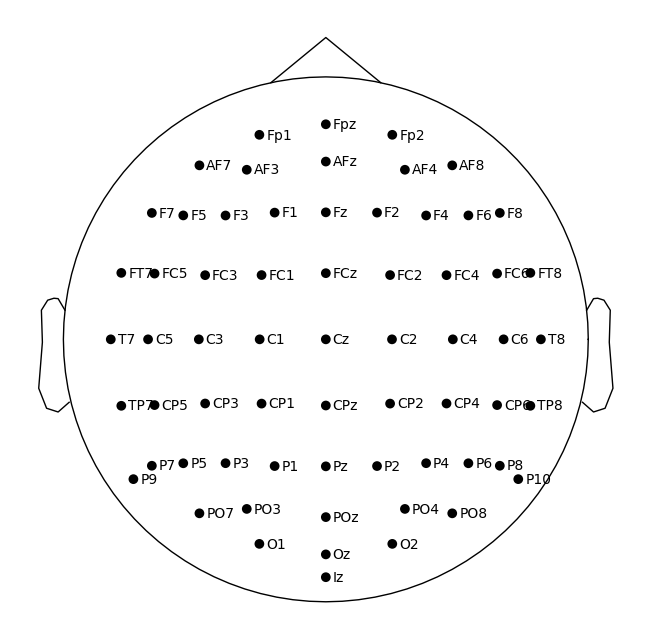

In [3]:
montage = make_standard_montage('biosemi64')
montage.plot();

In [4]:
raw = mne.io.read_raw_fif('../../../Thesis/openmiir/raw_data/P01-raw.fif', preload = True)
raw.info

Opening raw data file ../../../Thesis/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


Measurement date,"January 28, 2015 17:39:57 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"61 EEG, 4 EOG, 1 Stimulus"
Bad channels,"P8, P10, T8"
EOG channels,"EXG1, EXG2, EXG3, EXG4"
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


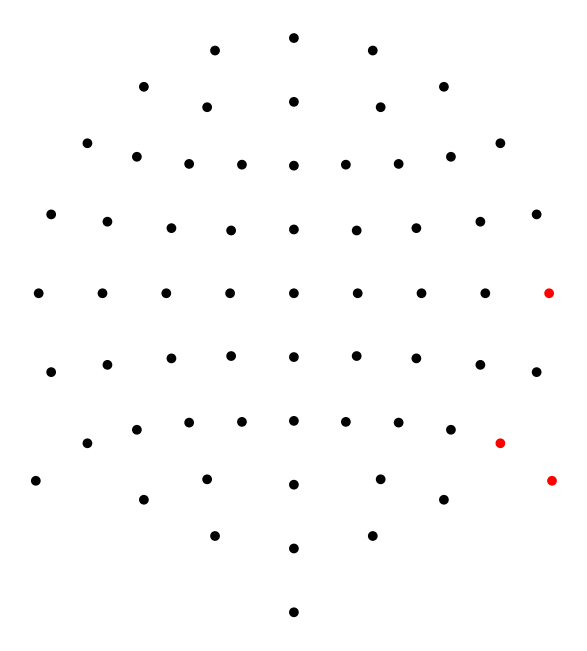

In [5]:
raw.plot_sensors();

In [6]:
p01 = "../../../Thesis/openmiir/raw_data/P01-raw.fif"
raw = mne.io.read_raw_fif(p01, preload = True)
#raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False)

Opening raw data file ../../../Thesis/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Define the number of participants, trials per participant, stimuli, and conditions
participants = ['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14']
trials_per_participant = 60
num_trials_per_stimulus = 5
stimuli = [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24]
conditions = ['Perception', 'Imagination_1', 'Imagination_2', 'Imagination_3']

# Create a list to store the data
data = []

# Generate the data for each participant, stimuli, and condition
# Create a list to store the data
data = []

# Generate the data for each participant, stimulus, and condition
for participant in participants:
    for stimulus in stimuli:
        # Shuffle the conditions for each stimulus
        random_conditions = random.sample(conditions, len(conditions))
        for condition_idx, condition in enumerate(random_conditions):
            data.append([participant, stimulus, condition, num_trials_per_stimulus])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Participant', 'Stimulus_ID', 'Condition', 'Num_Trials'])

# Display the DataFrame
print(df)

# Group the DataFrame by Stimulus_ID and Condition and calculate the total number of trials
grouped_df = df.groupby(['Stimulus_ID', 'Condition']).sum().reset_index()

"""# Create a bar plot
plt.figure(figsize=(12, 6))
for idx, stimulus_id in enumerate(stimuli):
    plt.subplot(3, 4, idx+1)
    subset_df = grouped_df[grouped_df['Stimulus_ID'] == stimulus_id]
    conditions = subset_df['Condition']
    num_trials = subset_df['Num_Trials']
    plt.bar(conditions, num_trials, color='skyblue')
    plt.title(f'Stimulus {stimulus_id}')
    plt.xlabel('Condition')
    plt.ylabel('Number of Trials')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""

    Participant  Stimulus_ID      Condition  Num_Trials
0           P01            1  Imagination_1           5
1           P01            1  Imagination_2           5
2           P01            1     Perception           5
3           P01            1  Imagination_3           5
4           P01            2  Imagination_2           5
..          ...          ...            ...         ...
475         P14           23  Imagination_1           5
476         P14           24  Imagination_2           5
477         P14           24  Imagination_1           5
478         P14           24  Imagination_3           5
479         P14           24     Perception           5

[480 rows x 4 columns]


"# Create a bar plot\nplt.figure(figsize=(12, 6))\nfor idx, stimulus_id in enumerate(stimuli):\n    plt.subplot(3, 4, idx+1)\n    subset_df = grouped_df[grouped_df['Stimulus_ID'] == stimulus_id]\n    conditions = subset_df['Condition']\n    num_trials = subset_df['Num_Trials']\n    plt.bar(conditions, num_trials, color='skyblue')\n    plt.title(f'Stimulus {stimulus_id}')\n    plt.xlabel('Condition')\n    plt.ylabel('Number of Trials')\n    plt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"

In [8]:
# read the preprocessed data to visualize psd for trials
from find_stimulus_length import get_start_and_end
file = "../../../Thesis/LONGER-EPOCHS-{}-preprocessed-precICA-raw.fif".format("P01")
raw_data = mne.io.read_raw_fif(file, preload = True)

events = mne.find_events(raw_data, stim_channel="STI 014")
stimulus_ids = events[:, -1]
print("stimulus_ids: ", sorted(set(stimulus_ids)))
eeg_picks = mne.pick_types(raw_data.info, meg=False, eeg=True, eog=False, stim=False, exclude=["EXG5", "EXG6"])
included_event_ids = [11,21,31,41,111,121,131,141,211,221,231,241] #perception only
filtered_events = []
for event in events:
    if event[-1] in included_event_ids:
        filtered_events.append(event)
labels = [event[2] for event in filtered_events]
for event in filtered_events:
    event = event.reshape(1,3)
    stimulus_id = event[0,2]
    
    song_id, condition_id = int(str(stimulus_id)[:-1]), int(str(stimulus_id)[-1]) #splitting stimulus id into song and condition
    #print("here: ", stimulus_id, song_id, condition_id)
    tmin, tmax = get_start_and_end(song_id, condition_id, "P01")#participant_id)
    #print("Length of song = ", tmax-tmin)

    #INDIVIDUAL LENGTHS
    epoch = mne.Epochs(raw_data, events=event, event_id=stimulus_id, tmin=tmin, tmax=tmax, #tmax=6.8709
    baseline=(None,None), verbose=False, picks=eeg_picks)
    print(stimulus_id)
    #epoch.compute_psd(fmin=0.5, fmax=30).plot() #epoch is exactly 1 epoch
    # 1 plot per epch, this is a lot actually want average across trials. see below

Opening raw data file ../../../Thesis/LONGER-EPOCHS-P01-preprocessed-precICA-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]
stimulus_ids:  [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44, 111, 112, 113, 114, 121, 122, 123, 124, 131, 132, 133, 134, 141, 142, 143, 144, 211, 212, 213, 214, 221, 222, 223, 224, 231, 232, 233, 234, 241, 242, 243, 244, 1111, 2001]
121
31
231
131
141
111
11
21
41
211
221
241
221
41
111
21
211
131
31
231
121
241
11
141
141
221
231
121
211
41
111
11
131
31
21
241
41
211
21
121

{1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24}
Plotting stim  1
Using data from preloaded Raw for 5 events and 7681 original time points ...
0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Plotting stim  2
Using data from preloaded Raw for 5 events and 7681 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Plotting stim  3
Using data from preloaded Raw for 5 events and 7681 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Plotting stim  4
Using data from preloaded Raw for 5 events and 7681 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Plotting stim  11
Using data from preloaded Raw for 5 events and 7681 original time points ...
0 bad epochs dropped
    Using multi

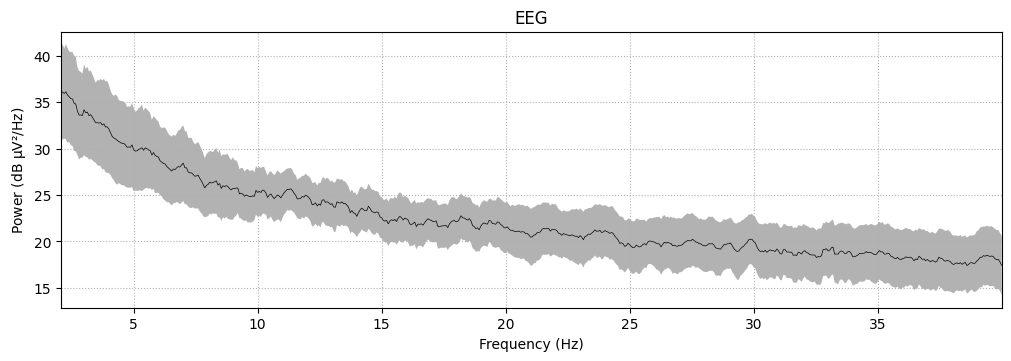

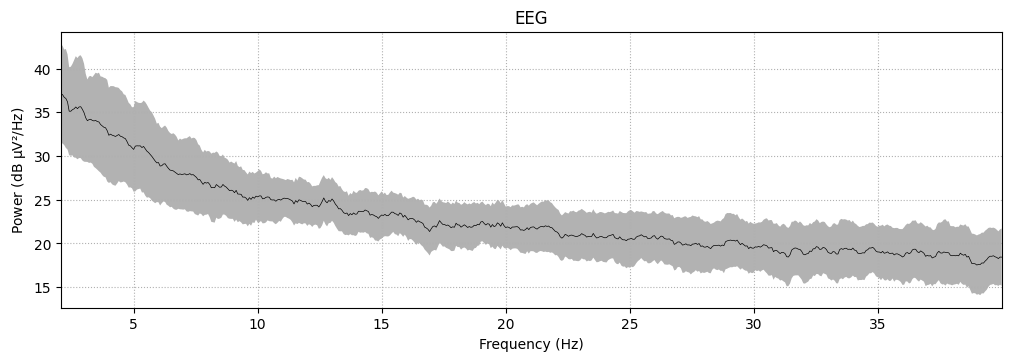

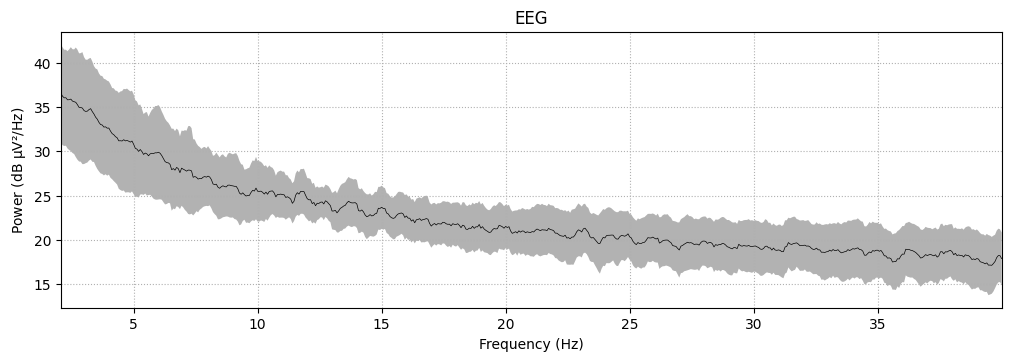

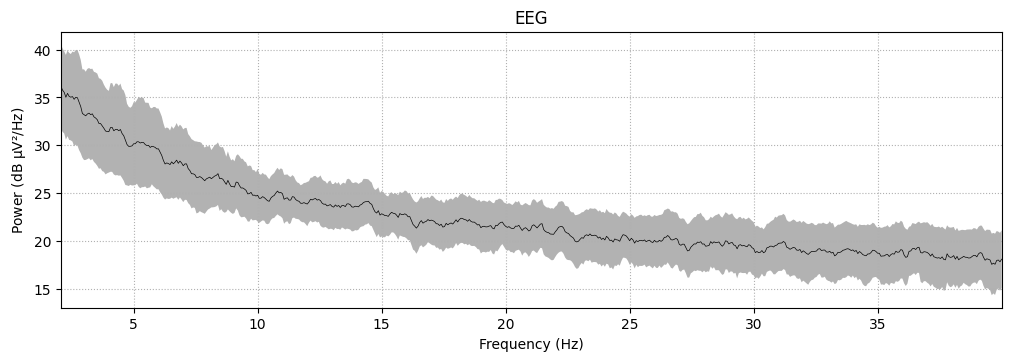

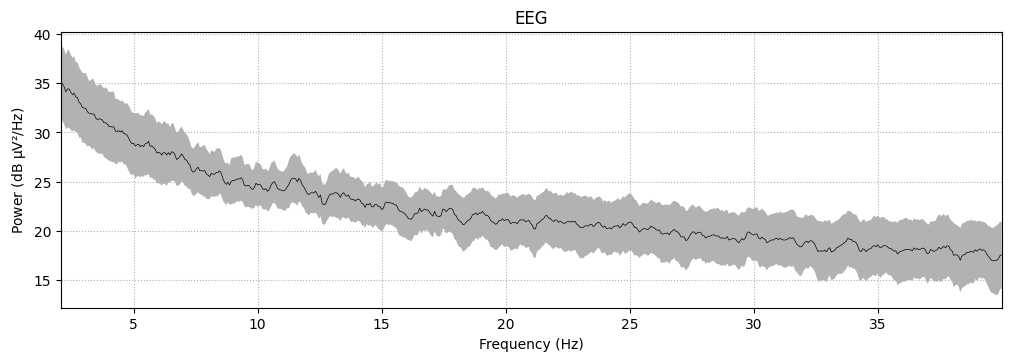

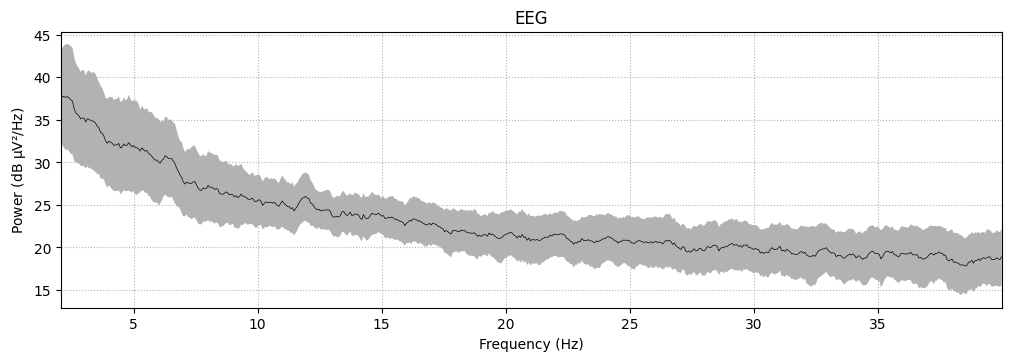

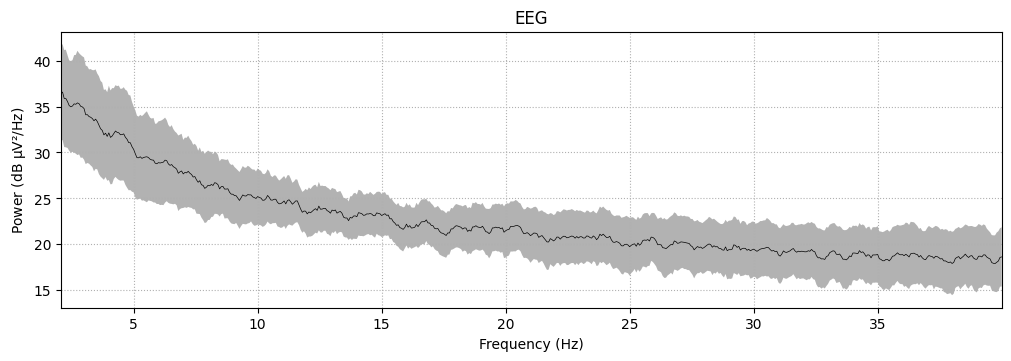

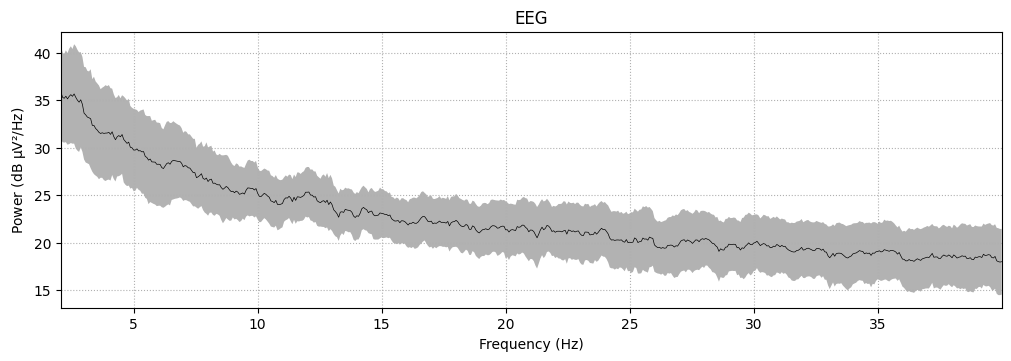

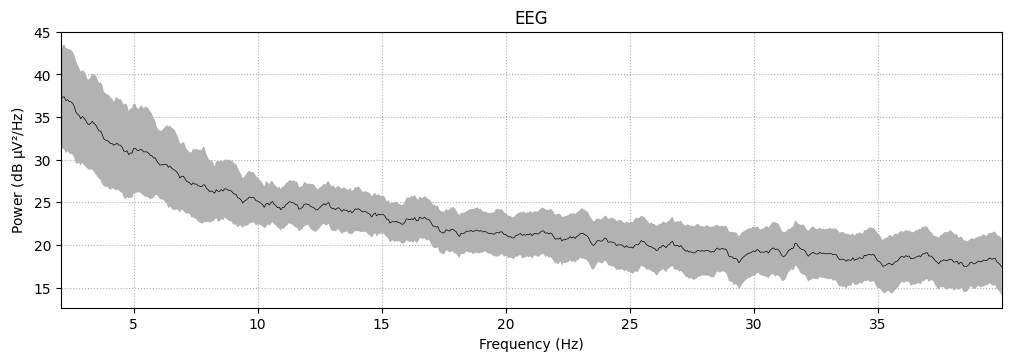

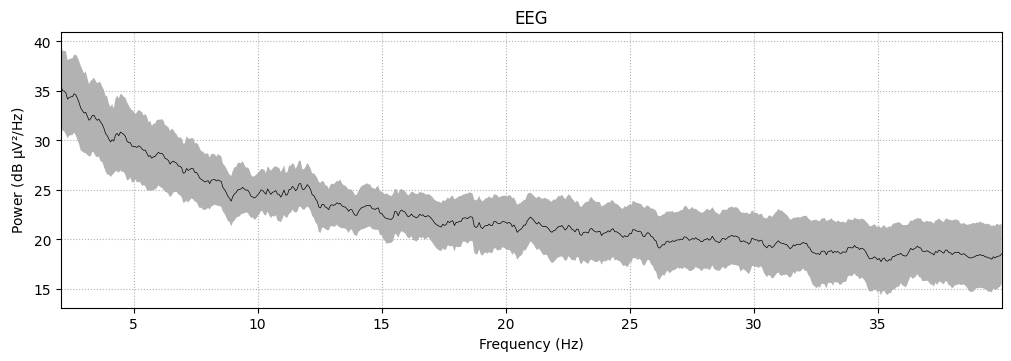

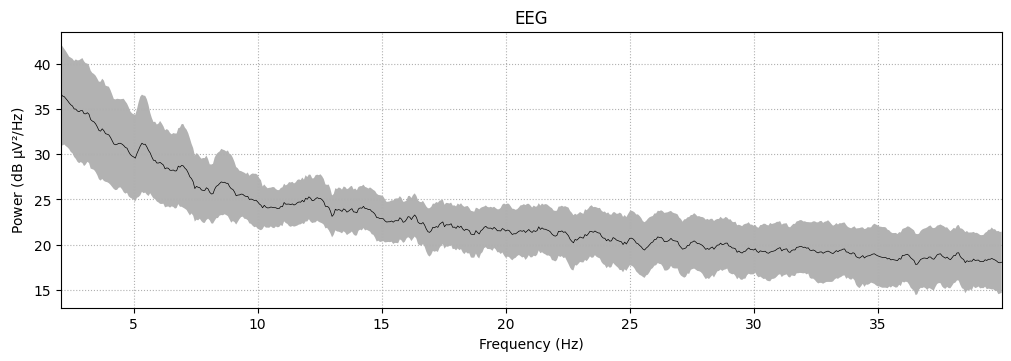

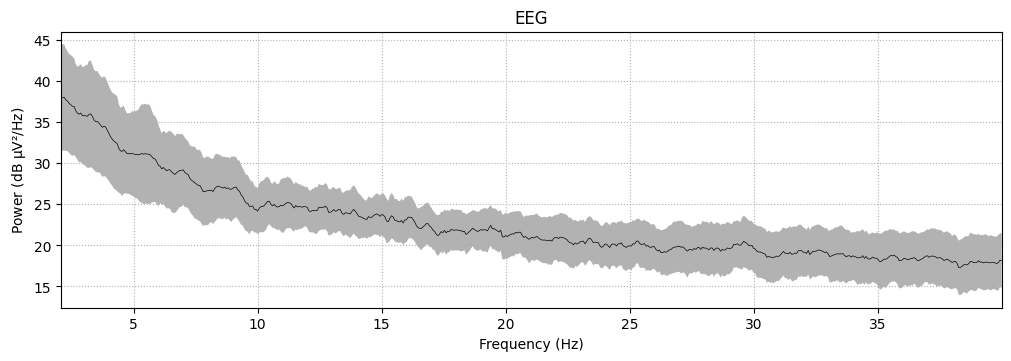

In [12]:
#time-frequency analysis
from mne.time_frequency import tfr_morlet

filtered_events = np.array([arr for arr in events if arr[2] in included_event_ids])

events_song_ids_only = np.array(np.array([[arr[0], arr[1], int(str(arr[2])[:-1])] for arr in filtered_events]))

print(set(events_song_ids_only[:,2]))

# plotting psd average of each stimulus
for stim in [1,2,3,4,11,12,13,14,21,22,23,24]:
    print("Plotting stim ", stim)
    #event_ids = [int(str(stim) + str(i)) for i in range(1, 5)]
    epochs = mne.Epochs(raw, events=events_song_ids_only, event_id=stim, tmin=0, tmax=15,
        baseline=(None,None), verbose=False, picks=eeg_picks)

    epochs.compute_psd(fmin=2.0, fmax=40.0).plot(
        average=True, amplitude=False, picks="data", exclude="bads")

Opening raw data file ../../../Thesis/LONGER-EPOCHS-P01-preprocessed-precICA-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]
stimulus_ids:  [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44, 111, 112, 113, 114, 121, 122, 123, 124, 131, 132, 133, 134, 141, 142, 143, 144, 211, 212, 213, 214, 221, 222, 223, 224, 231, 232, 233, 234, 241, 242, 243, 244, 1111, 2001]
Group ID: 1 Stimulus IDs: [11]
Length of song: 14.9657
Using data from preloaded Raw for 5 events and 7663 original time points ...
0 bad epochs dropped
Group ID: 2 Stimulus IDs: [21]
Length of song: 9.5352
Using data from preloaded Raw for 5 events and 4883 original time points ...
0 bad epochs dropped
Group ID: 3 Stimulus IDs: [31]
Length of song: 11.9797
Using data from preloaded Raw for 5 events and 6135 original time points ...
0 ba

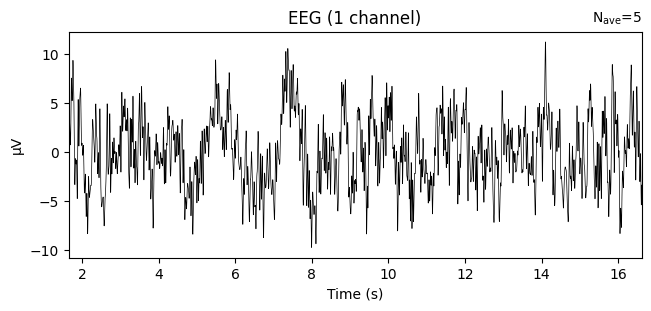

Group ID: 2
Need more than one channel to make topography for eeg. Disabling interactivity.


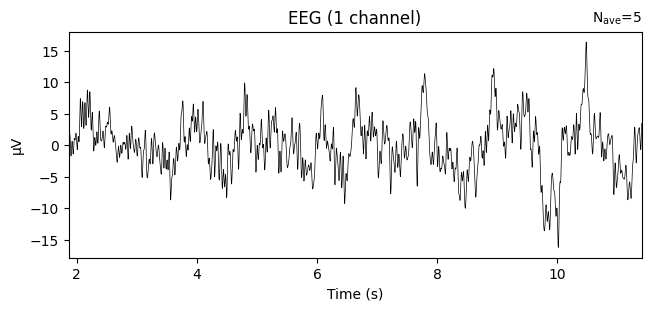

Group ID: 3
Need more than one channel to make topography for eeg. Disabling interactivity.


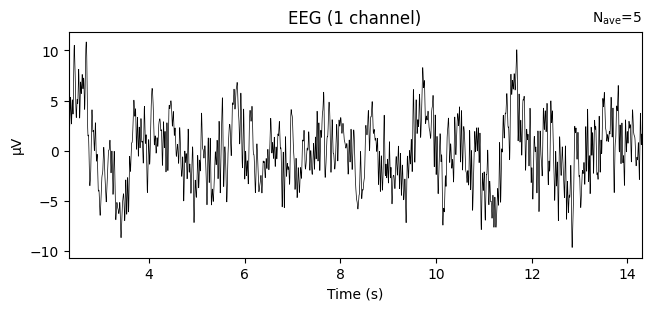

Group ID: 4
Need more than one channel to make topography for eeg. Disabling interactivity.


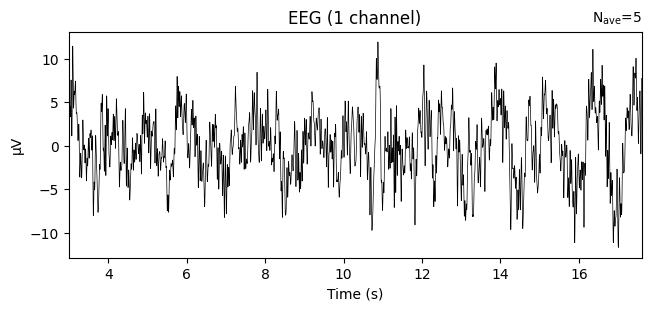

Group ID: 11
Need more than one channel to make topography for eeg. Disabling interactivity.


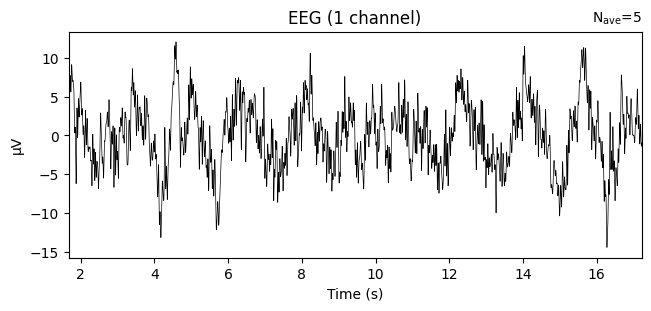

Group ID: 12
Need more than one channel to make topography for eeg. Disabling interactivity.


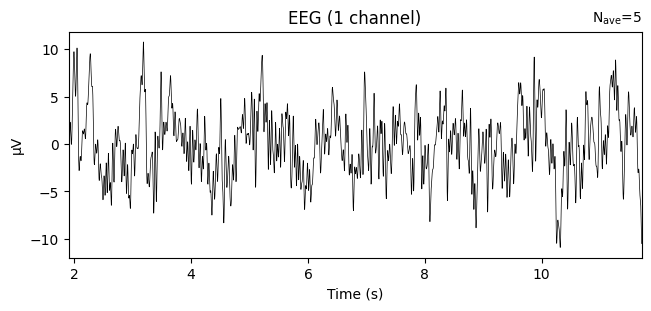

Group ID: 13
Need more than one channel to make topography for eeg. Disabling interactivity.


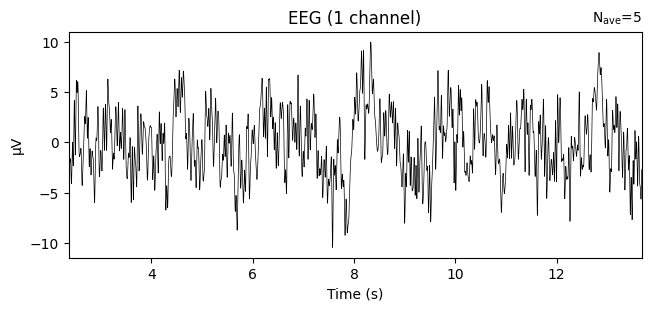

Group ID: 14
Need more than one channel to make topography for eeg. Disabling interactivity.


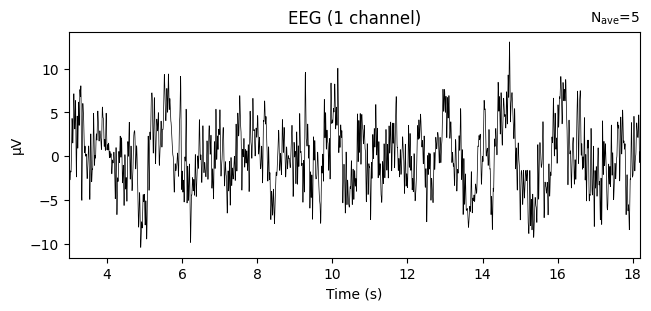

Group ID: 21
Need more than one channel to make topography for eeg. Disabling interactivity.


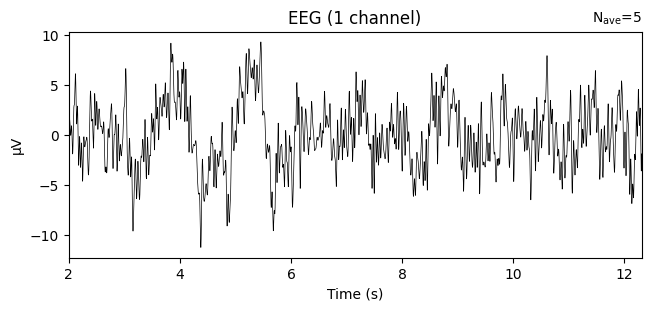

Group ID: 22
Need more than one channel to make topography for eeg. Disabling interactivity.


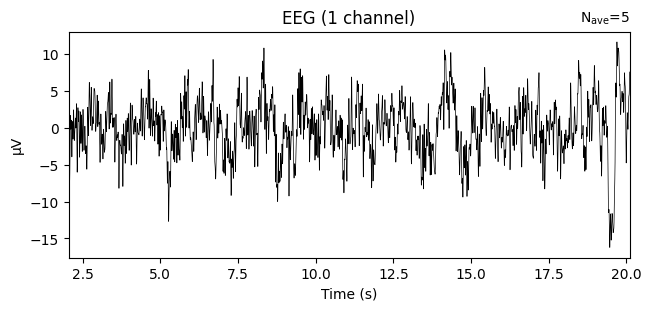

Group ID: 23
Need more than one channel to make topography for eeg. Disabling interactivity.


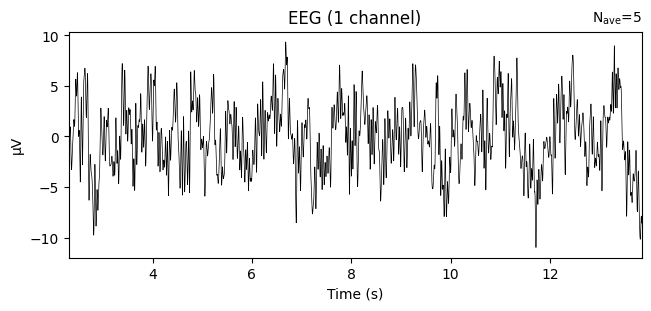

Group ID: 24
Need more than one channel to make topography for eeg. Disabling interactivity.


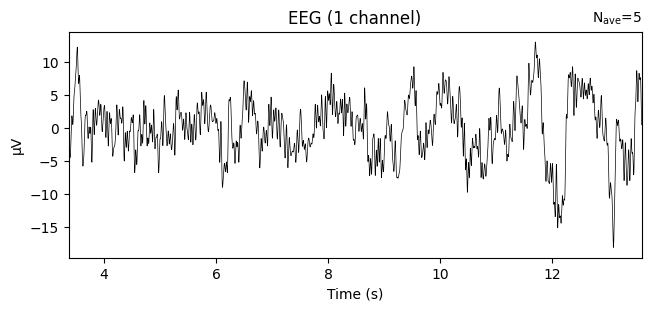

In [16]:
import mne

# read the preprocessed data to visualize psd for trials
# only participant 1 for now 
from find_stimulus_length import get_start_and_end
file = "../../../Thesis/LONGER-EPOCHS-{}-preprocessed-precICA-raw.fif".format("P01")
raw_data = mne.io.read_raw_fif(file, preload=True)

events = mne.find_events(raw_data, stim_channel="STI 014")
stimulus_ids = events[:, -1]
print("stimulus_ids: ", sorted(set(stimulus_ids)))
eeg_picks = mne.pick_types(raw_data.info, meg=False, eeg=False, eog=False, stim=False, include = ["T8"], exclude=["EXG5", "EXG6"])
# eeg = True to include all channels
included_event_ids = [11, 21, 31, 41, 111, 121, 131, 141, 211, 221, 231, 241]  # perception only

# Create a dictionary to group stimulus IDs
grouped_stimulus_ids = {}

for stimulus_id in included_event_ids:
    # Group stimulus ID without the last digit
    group_id = stimulus_id // 10

    # Append current stimulus ID to the corresponding group
    if group_id not in grouped_stimulus_ids:
        grouped_stimulus_ids[group_id] = [stimulus_id]
    else:
        grouped_stimulus_ids[group_id].append(stimulus_id)

# Create a list to store all epochs
all_epochs = []

# Iterate over grouped stimulus IDs
for group_id, stimulus_ids in grouped_stimulus_ids.items():
    print("Group ID:", group_id, "Stimulus IDs:", stimulus_ids)

    group_events = [event for event in events if event[-1] in stimulus_ids]

    # Extract song and condition IDs from the first stimulus ID in the group
    song_id, condition_id = int(str(stimulus_ids[0])[:-1]), int(str(stimulus_ids[0])[-1])

    # Get start and end times based on song and condition IDs
    tmin, tmax = get_start_and_end(song_id, condition_id, "P01")  # participant_id

    print("Length of song:", tmax - tmin)

    # Create epochs for the current group of stimulus IDs
    epoch = mne.Epochs(raw_data, events=group_events, event_id=None, tmin=tmin, tmax=tmax,
                       baseline=(None, None), verbose=False, picks=eeg_picks)
    epoch = epoch.drop_bad(reject='existing', flat='existing', verbose=None)

    # Append epochs to the list
    all_epochs.append(epoch)

# Average epochs for each group of stimulus IDs
for group_id, epoch in zip(grouped_stimulus_ids.keys(), all_epochs):
    print("Group ID:", group_id)
    epoch.average().plot()  # Plot the average epoch for each group of stimulus IDs

In [ ]:
epochs11 = mne.Epochs(raw, events=filtered_events, event_id=11, tmin=0, tmax=15,
        baseline=(None,None), verbose=False, picks=eeg_picks)
x = epochs11.compute_tfr(method="morlet", freqs=np.array([1,20,50]))
print(x)
print(x[0])
x[0].plot();

### Confusion matrix of baseline + correct results of binary information


This is with test_size = 0.2/0.3(?) but also did leave-one-participant-out, then only 5 predictions per stimulus though

In [18]:
import seaborn as sns
import numpy as np
import pandas as pd

In [7]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

<Axes: >

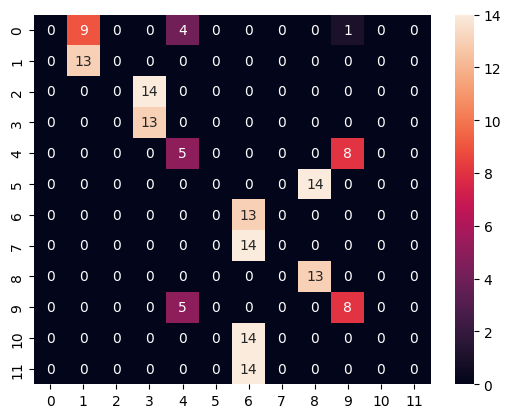

In [6]:
cf = np.array([
    [0, 9, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0],
    [0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0]
])

sns.heatmap(cf, annot=True,)
 

In [9]:
import matplotlib.pyplot as plt

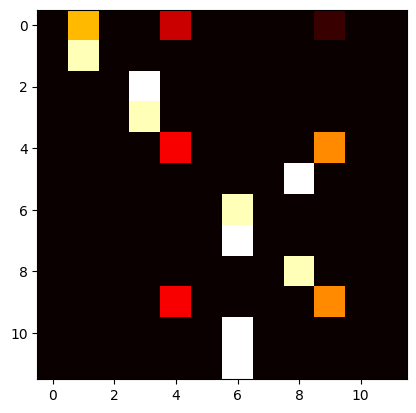

In [10]:
plt.imshow(cf, cmap='hot', interpolation='nearest')

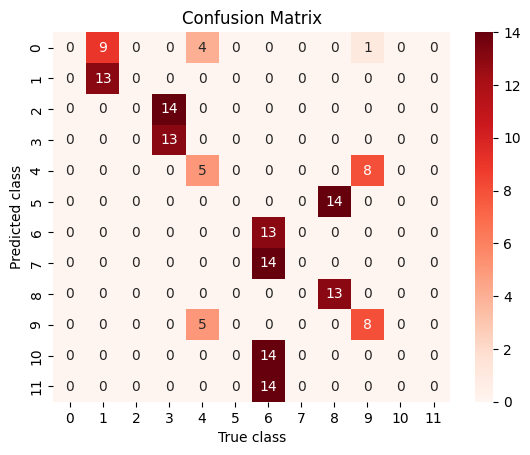

In [16]:
import seaborn as sns
%matplotlib inline
stim_ids = [1,2,3,4,11,12,13,14,21,22,23,24]
sns.heatmap(cf, annot=True, cmap="Reds")
plt.xlabel('True class')
plt.ylabel('Predicted class')
#plt.xticks(stim_ids)
#plt.yticks(stim_ids)
plt.title("Confusion Matrix")
plt.show()

In [21]:
indices = [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24]
columns = indices

# Create DataFrame
df = pd.DataFrame(data=cf, index=indices, columns=columns)

print(df)

    1   2   3   4   11  12  13  14  21  22  23  24
1    0   9   0   0   4   0   0   0   0   1   0   0
2    0  13   0   0   0   0   0   0   0   0   0   0
3    0   0   0  14   0   0   0   0   0   0   0   0
4    0   0   0  13   0   0   0   0   0   0   0   0
11   0   0   0   0   5   0   0   0   0   8   0   0
12   0   0   0   0   0   0   0   0  14   0   0   0
13   0   0   0   0   0   0  13   0   0   0   0   0
14   0   0   0   0   0   0  14   0   0   0   0   0
21   0   0   0   0   0   0   0   0  13   0   0   0
22   0   0   0   0   5   0   0   0   0   8   0   0
23   0   0   0   0   0   0  14   0   0   0   0   0
24   0   0   0   0   0   0  14   0   0   0   0   0


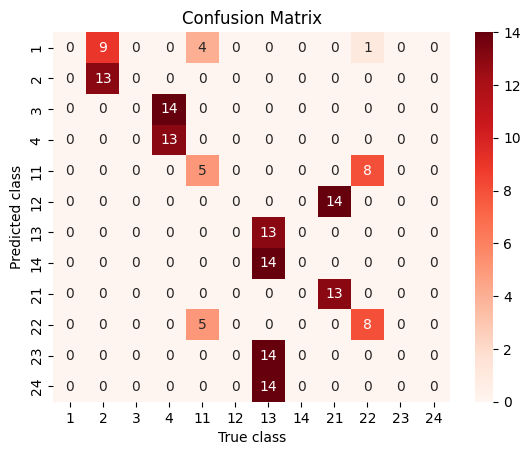

In [22]:
sns.heatmap(df, annot=True, cmap="Reds")

# Set x and y tick positions to be at the center of the cells
plt.xticks(ticks=np.arange(len(df.columns)) + 0.5, labels=df.columns)
plt.yticks(ticks=np.arange(len(df.index)) + 0.5, labels=df.index)

# Labels and title
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.title("Confusion Matrix Song Classification")

# Show the plot
plt.show()